<a href="https://colab.research.google.com/github/tylerlum/deep_learning_monte_carlo_dropout/blob/main/mc_dropout_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [8]:
model = get_model(mc=False, act="relu")
mc_model = get_model(mc=True, act="relu")

In [9]:
h = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=1,
              validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 2.2856 - accuracy: 0.1321 - val_loss: 2.2515 - val_accuracy: 0.2360
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 2.2311 - accuracy: 0.2254 - val_loss: 2.1861 - val_accuracy: 0.4024
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 2.1639 - accuracy: 0.3134 - val_loss: 2.1007 - val_accuracy: 0.5347
Epoch 4/10
469/469 [==============================] - 4s 10ms/step - loss: 2.0724 - accuracy: 0.3961 - val_loss: 1.9853 - val_accuracy: 0.6358
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 1.9554 - accuracy: 0.4665 - val_loss: 1.8338 - val_accuracy: 0.6915
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 1.8088 - accuracy: 0.5282 - val_loss: 1.6474 - val_accuracy: 0.7315
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 1.6396 - accuracy: 0.5767 - val_loss: 1.4413 - val_accuracy: 0.7605

In [36]:
def plot_train_validation(history, plot_type):
  plt.plot(h.history[plot_type])
  plt.plot(h.history[f'val_{plot_type}'])
  plt.title(f'model {plot_type}')
  plt.ylabel(plot_type)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

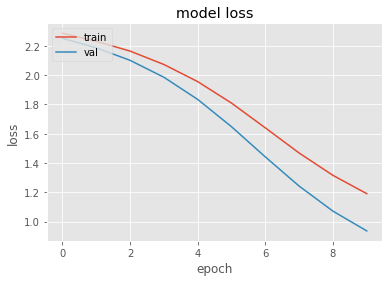

In [37]:
plot_train_validation(h, "loss")

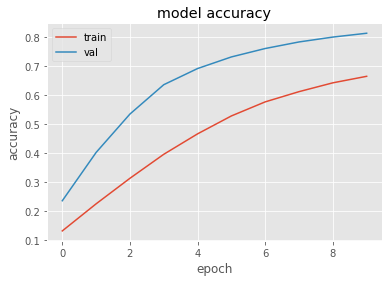

In [38]:
plot_train_validation(h, "accuracy")

In [10]:
# score of the normal model
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9359776377677917
Test accuracy: 0.8130999803543091


In [11]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 5s 10ms/step - loss: 2.2764 - accuracy: 0.1528 - val_loss: 2.2556 - val_accuracy: 0.1918
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 2.2319 - accuracy: 0.2387 - val_loss: 2.2025 - val_accuracy: 0.2939
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 2.1692 - accuracy: 0.3269 - val_loss: 2.1265 - val_accuracy: 0.3778
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 2.0830 - accuracy: 0.4026 - val_loss: 2.0255 - val_accuracy: 0.4408
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 1.9634 - accuracy: 0.4770 - val_loss: 1.8888 - val_accuracy: 0.5079
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 1.8161 - accuracy: 0.5347 - val_loss: 1.7221 - val_accuracy: 0.5711
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 1.6396 - accuracy: 0.5913 - val_loss: 1.5369 - val_accuracy: 0.6148

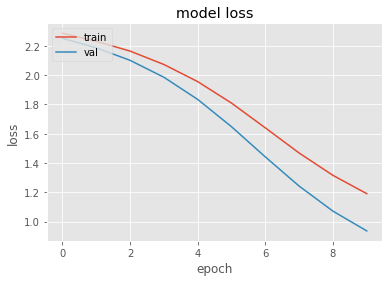

In [39]:
plot_train_validation(h_mc, "loss")

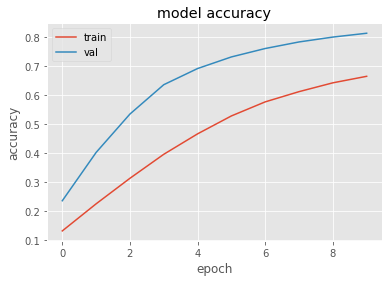

In [40]:
plot_train_validation(h_mc, "accuracy")

In [12]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


In [13]:
# score of the mc model
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))

MC accuracy: 70.0%


In [14]:
mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test.argmax(axis=1), mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))

MC-ensemble accuracy: 83.8%


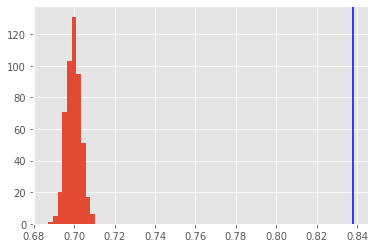

In [15]:
plt.hist(accs)
plt.axvline(x=ensemble_acc, color="b")

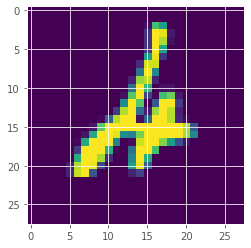

In [16]:
idx = 247
plt.imshow(x_test[idx][:,:,0])

In [17]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 6
true label: 4

class: 0; proba: 2.2%; var: 1.55% 
class: 1; proba: 5.9%; var: 3.90% 
class: 2; proba: 24.7%; var: 10.47% 
class: 3; proba: 4.8%; var: 3.12% 
class: 4; proba: 8.2%; var: 5.33% 
class: 5; proba: 3.9%; var: 2.44% 
class: 6; proba: 41.1%; var: 13.28% 
class: 7; proba: 0.8%; var: 0.67% 
class: 8; proba: 5.2%; var: 3.66% 
class: 9; proba: 3.2%; var: 2.56% 


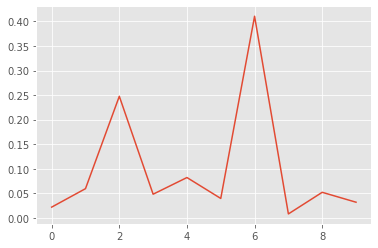

In [18]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

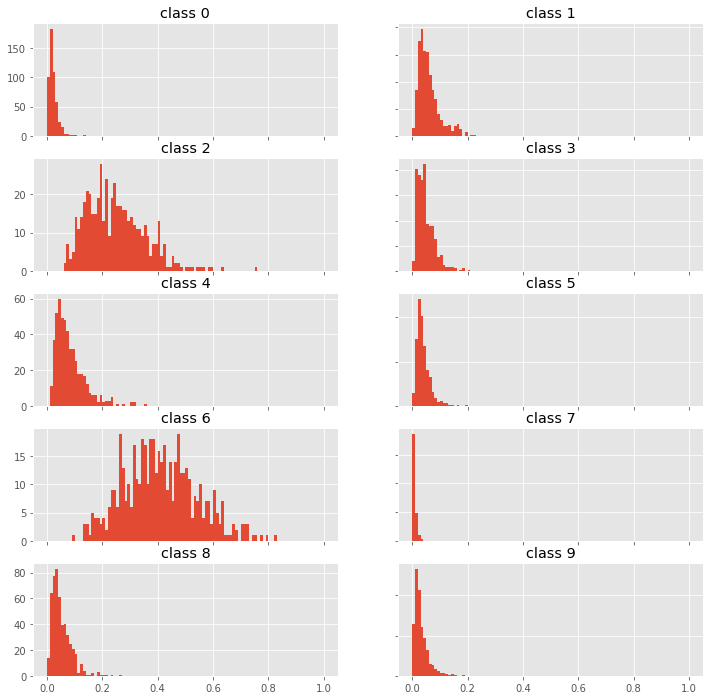

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()

In [20]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [21]:
(np.array(max_means)).argsort()[:10]

array([191,  96, 189, 483, 195, 346, 443, 478,  59, 498])

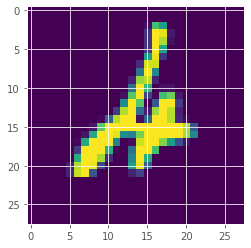

In [22]:
plt.imshow(x_test[247][:,:,0])

In [23]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

In [24]:
(-np.array(max_vars)).argsort()[:10]

array([ 48, 390, 311, 222, 405,  95, 462, 353, 461, 186])

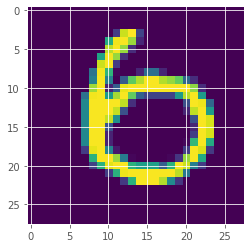

In [25]:
plt.imshow(x_test[259][:,:,0])

In [26]:
random_img = np.random.random(input_shape)

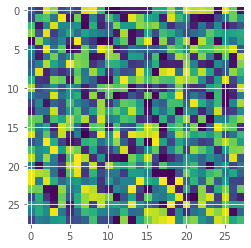

In [27]:
plt.imshow(random_img[:,:,0]);

In [28]:
random_predictions = []
for i in tqdm.tqdm(range(500)):
    y_p = mc_model.predict(np.array([random_img]))
    random_predictions.append(y_p)

100%|██████████| 500/500 [00:15<00:00, 33.00it/s]


In [29]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 0

class: 0; proba: 28.5%; var: 17.37% 
class: 1; proba: 0.6%; var: 0.74% 
class: 2; proba: 21.8%; var: 16.52% 
class: 3; proba: 11.4%; var: 9.35% 
class: 4; proba: 7.3%; var: 7.87% 
class: 5; proba: 14.9%; var: 12.42% 
class: 6; proba: 3.2%; var: 4.13% 
class: 7; proba: 1.9%; var: 2.57% 
class: 8; proba: 8.6%; var: 6.88% 
class: 9; proba: 1.8%; var: 2.67% 


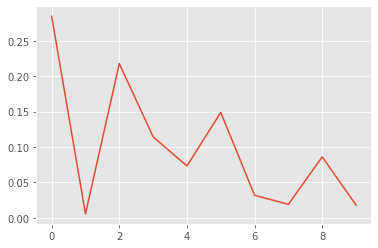

In [30]:
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y)

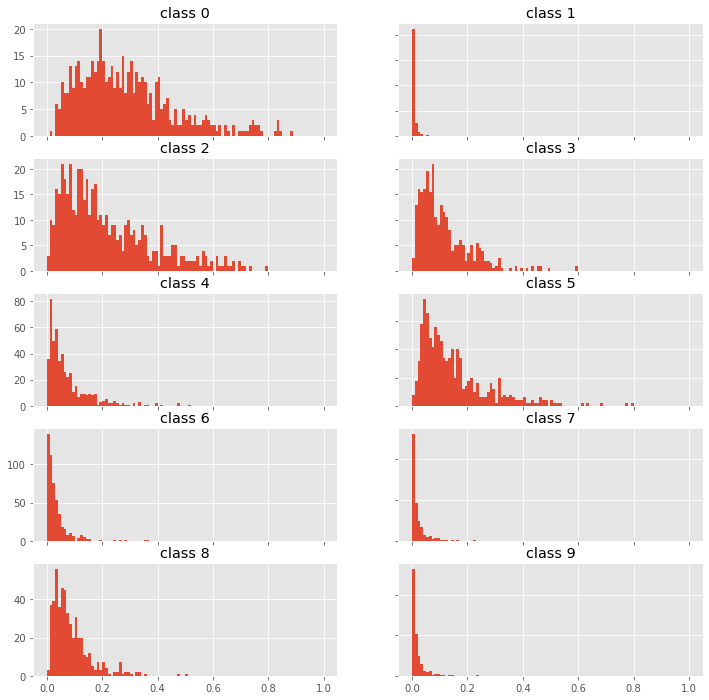

In [31]:
fig, axes = plt.subplots(5, 2, figsize=(12,12))

for i, ax in enumerate(fig.get_axes()):
    ax.hist(p0[:,i], bins=100, range=(0,1))
    ax.set_title(f"class {i}")
    ax.label_outer()